# Python Practice Lecture 16 MATH 342W Queens College - K-fold Cross Validation
## Author: Amir ElTabakh
## Date: April 5, 2022

## Agenda:
* The K Tradeoff
* Reducing variance with Cross Validation (i.e. K-fold CV)

## The K Tradeoff

$K$ determines how large the training set is relative to the test set when you're doing honest validation for an algorithm. For now, let's not use K-fold CV, but only examine one split at a time. Consider this simulated dataset with 50 observations:

In [1]:
# importing dependencies
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # calculates RMSE
import pandas as pd
import random

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind")) # setting color palette
sns.set(rc={"figure.figsize":(10, 6)}) #width=10, #height=6

In [2]:
# setting seed
np.random.seed(2022)

# constants
n = 50
xmin = 0
xmax = 4

# data vecs
x = np.random.uniform(low = xmin, high = xmax, size = n)
y = [2 + 3 * i ** 2 + np.random.normal(0, 0.8) for i in x]

# convert to df
Xy = pd.DataFrame({'y': y, 'x': x})

# snapshot
Xy.head()

,y,x
0,1.475622,0.037434
1,13.308573,1.996231
2,3.327321,0.453535
3,1.945917,0.199896
4,23.797992,2.741630


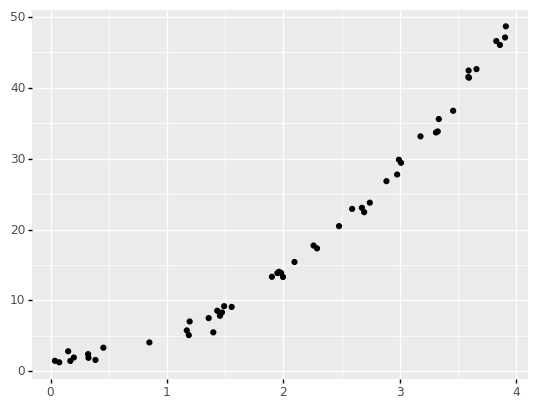

<ggplot: (143102508776)>

In [3]:
from plotnine import ggplot, aes, geom_point

# plot the data
data_plot = ggplot(Xy) + aes(x = x, y = y) + geom_point()
data_plot

Note how $f(x)$ is quadratic and there is random noise which is "ignorance error". The random noise will be part of generalization error and can never go away.

If we use OLS with no derived features, then we can at most get $h*(x)$. Let's see what $h^*(x) = \beta_0 + \beta_1 x$ truly is. To do this, we imagine we see an absolute ton of data and run OLS on it.

In [4]:
# setting seed
np.random.seed(1738)

n_hidden = 1e6

# data vecs
x_hidden = np.random.uniform(low = xmin, high = xmax, size = n)
y_hidden = [2 + 3 * i ** 2 + np.random.normal(0, 0.8) for i in x_hidden]

# convert to dataframes
x_hidden = pd.DataFrame(x_hidden)
y_hidden = pd.DataFrame(y_hidden)


# h_*
h_star_model = LinearRegression().fit(x_hidden, y_hidden)

print(h_star_model.intercept_[0], h_star_model.coef_[0][0])

-5.7301681875688715 11.925324444538758


The fact that $\beta = [-6~12]^\top$ can actually be solved with calculus: $\int_0^4 ((2 + 3x^2) - (b_0 + b_1 x))^2 dx$ and solve for $b_0$ and $b_1$ explicitly by minimizing.

Plotting that over $\mathbb{D}$ we obtain

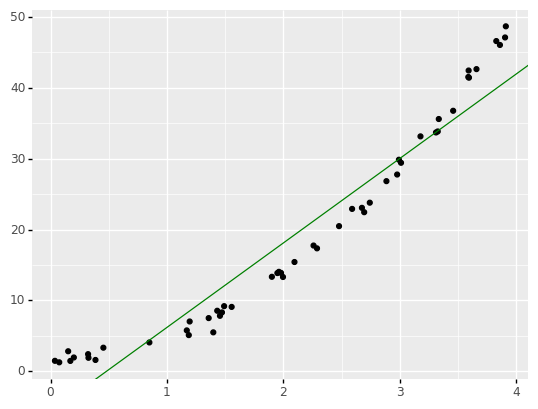

<ggplot: (143102522356)>

In [5]:
from plotnine import geom_abline

data_plot + geom_abline(
    intercept = h_star_model.intercept_[0],
    slope = h_star_model.coef_[0][0],
    color = 'green')

That is the best we're going to get. However, $g_{final}$ falls far short of it:

In [6]:
# h_*
g_final_model = LinearRegression().fit(Xy[['x']], Xy[['y']])

print(g_final_model.intercept_[0], g_final_model.coef_[0][0])

-5.779880916597136 12.040200380319078


The actual standard error of g_final can be estimated by imagining tons of future observations:

In [7]:
y_hat_g_final = g_final_model.predict(x_hidden)

gen_error_true = np.std(y_hidden - y_hat_g_final)
gen_error_true[0]

3.895685515342658

The model $g$ can vary quite a bit as we subsample $\mathbb{D}$ which is what happens when you do train-test splits. It varies a lot because there is large misspecification error. If the model was correctly specified, the results of everything that follows will be less impressive. But in the real world - is your model ever correctly specified? is $f \in \mathcal{H}$?? NO. So this is more realistic.

Now let's let K be small. Let K = 2 meaning even 50-50 split of test and train.

Sets, initialized with paranthesis, not square brackets, allow us to reduce one list from the other using the subtract operator.

In [8]:
# setting seed
random.seed(17388) # two different libraries to set seeds for

# constants
K = 2
prop_train = (K - 1) / K
n_train = int(prop_train * n)

# train test split indices
indices = set([i for i in range(n)])
index_train = set(random.sample(indices, n_train))
index_test = indices - index_train

# split based on indices
x_train = pd.DataFrame([x[i] for i in index_train]) # cast from set to list
y_train = pd.DataFrame([y[i] for i in index_train])

x_test = pd.DataFrame([x[i] for i in index_test])
y_test = pd.DataFrame([y[i] for i in index_test])

# fitting model
g_mod = LinearRegression().fit(x_train, y_train)

# yhat via test set
y_hat_g_test = g_mod.predict(x_test)

# yhat via train set
y_hat_g_train = g_mod.predict(x_train)

# standard error
gen_error_K_2_test = np.std(y_test - y_hat_g_test) # test
gen_error_K_2_train = np.std(y_train - y_hat_g_train) # train

print(gen_error_true[0]) # true standard error
print(gen_error_K_2_test[0]) # tested standard error

3.895685515342658
3.866651151341103


Although I cooked the books by setting the seed, this realization makes sense. If K=2, I build the model g with half the data than the model g_final. Less data to train on => higher generalization error. How about if K is large. Let's say $K = \frac{n}{2}$ meaning $n_{train} = 48$ and $n_{test} = 2$.

In [9]:
# setting seed
np.random.seed(7777)
random.seed(7777) # two different libraries to set seeds for

# constants
K = n / 2
prop_train = (K - 1) / K
n_train = int(prop_train * n)

# train test split indices
indices = set([i for i in range(n)])
index_train = set(random.sample(indices, n_train))
index_test = indices - index_train

# split based on indices
x_train = pd.DataFrame([x[i] for i in index_train]) # cast from set to list
y_train = pd.DataFrame([y[i] for i in index_train])

x_test = pd.DataFrame([x[i] for i in index_test])
y_test = pd.DataFrame([y[i] for i in index_test])

# fitting model
g_mod = LinearRegression().fit(x_train, y_train)

# yhat via test set
y_hat_g_test = g_mod.predict(x_test)

# yhat via train set
y_hat_g_train = g_mod.predict(x_train)

# standard error
gen_error_K_2_test = np.std(y_test - y_hat_g_test) # test
gen_error_K_2_train = np.std(y_train - y_hat_g_train) # train

print(gen_error_true[0]) # true standard error
print(gen_error_K_2_test[0]) # tested standard error
print(gen_error_K_2_train[0]) # train standard error

3.895685515342658
4.721271620787243
3.9750058046527084


Although I cooked the books again by setting the seed, this also makes sense. More data to train on means less error but still more error than all the data. In reality, there is massive variance over specific splits! Let's run the simulation with these two K values many times.

While we're at it, let's do all K's! Well, what are all the valid K's? If you want to keep the sizes the same, any factorization of n except the trivial 1 since n = 1 * n. A $K = 1$ would mean there's no split! How to find divisors? Of course a package for this.

In [10]:
# import divisors() method from sympy
from sympy import divisors

Kuniques = list(set(divisors(n)) - set([1]))
Kuniques

[2, 5, 10, 50, 25]

But should we also include the trivial n? Yes K = n is indeed a valid divisor. And this type of CV is called the "leave one out cross validation" (LOOCV). Now we compute the errors over K:

In [11]:
# constants
Nsim_per_K = 2000 # simulations per K fold
num_Kuniques = len(Kuniques)
Ks = Kuniques * Nsim_per_K

results = pd.DataFrame({'standard_error': [0 for i in range(Nsim_per_K * num_Kuniques)],
                        'K': [0 for i in range(Nsim_per_K * num_Kuniques)]})

for i in range(len(Ks)):
    # constants
    K = Ks[i]
    prop_train = (K - 1) / K
    n_train = int(prop_train * n)

    # train test split indices
    indices = set([i for i in range(n)])
    index_train = set(random.sample(indices, n_train))
    index_test = indices - index_train

    # split based on indices
    X_train = pd.DataFrame([x[i] for i in index_train]) # cast from set to list
    y_train = pd.DataFrame([y[i] for i in index_train])

    X_test = pd.DataFrame([x[i] for i in index_test])
    y_test = pd.DataFrame([y[i] for i in index_test])

    # fitting model
    g_mod = LinearRegression().fit(X_train, y_train)
    
    # get predictions
    y_hat_g = g_mod.predict(X_test)
    
    # get error metric
    if len(y_test) == 1:
        g_s_e = np.absolute([float(y_test.iloc[i]) - y_hat_g[i] for i in range(len(y_test))])
    else:
        g_s_e = np.std([float(y_test.iloc[i]) - y_hat_g[i] for i in range(len(y_test))])
    
    # update results
    results.loc[i] = np.asarray([g_s_e, K])
    
# output results
results

,standard_error,K
0,4.854482,2.0
1,2.285150,5.0
2,3.105590,10.0
3,7.310184,50.0
4,0.852891,25.0
...,...,...
9995,4.322564,2.0
9996,2.757709,5.0
9997,3.843814,10.0
9998,3.889604,50.0


What are the variabilities? Let's take the average error over each simulated split. 

In [12]:
# mean of the standard errors grouped by K
results_summary = pd.DataFrame({'K': list(results.groupby(['K']).mean().index),
                                 'K_avg': list(results.groupby(['K']).mean()['standard_error']),
                                 'K_SE': list(results.groupby(['K']).std()['standard_error'])
                                }).set_index('K')

results_summary

,K_avg,K_SE
K,,
2.0,4.138852,0.349815
5.0,3.923679,0.598949
10.0,3.586957,0.995828
25.0,2.351176,1.800594
50.0,3.716647,1.875211


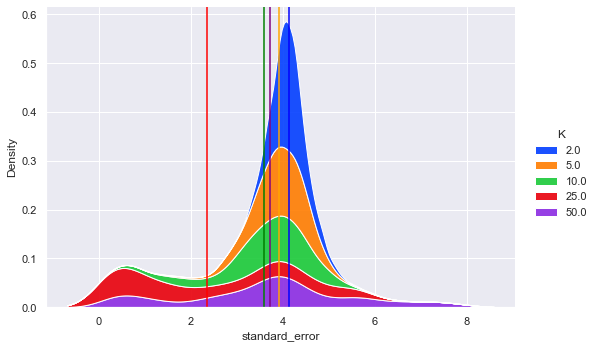

In [13]:
sns.displot(results,
             x = 'standard_error',
             hue = 'K',
             kind = 'kde',
             multiple="stack",
             palette = 'bright',
             alpha = 0.9,
             aspect = 1.5) # width = height * aspect

plt.axvline(label='Mean 2.0', x=results_summary.iloc[0, 0], color='blue')
plt.axvline(label='Mean 5.0', x=results_summary.iloc[1, 0], color='orange')
plt.axvline(label='Mean 10.0', x=results_summary.iloc[2, 0], color='green')
plt.axvline(label='Mean 25.0', x=results_summary.iloc[3, 0], color='red')
plt.axvline(label='Mean 50.0', x=results_summary.iloc[4, 0], color='purple')

The main takeaways are

1. The std err of generalization error estimate is much lower for low K than high K

With high K, the test set is small meaning the estimate has high variance; with low K, the test set is large meaning you can measure it with low variance.

2. The average of generalization error estimate is lower for high K than low K

With high K, the training set is large meaning $g$ is closer to g_final and thus has higher expected accuracy; with low K, the training set is small meaning $g$ is further from g_final and thus has lower expected accuracy.

Thus, the tradeoff is bias vs. variance. There are many similar tradeoffs in statistics. We will see one later when we do machine learning.

Is the estimates' accuracy for what we really care about? No, the generalization error of g_final which we picture below:

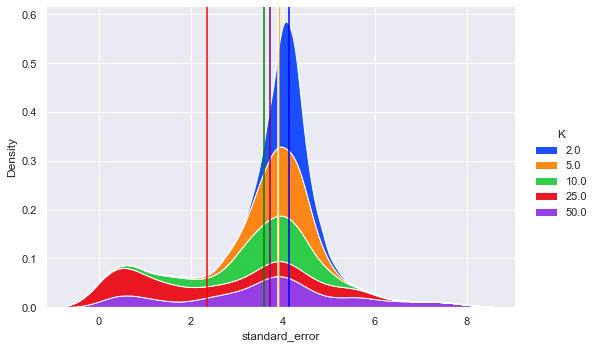

In [14]:
sns.displot(results,
             x = 'standard_error',
             hue = 'K',
             kind = 'kde',
             multiple="stack",
             palette = 'bright',
             alpha = 0.9,
             aspect = 1.5) # width = height * aspect

plt.axvline(label='Mean 2.0', x=results_summary.iloc[0, 0], color='blue')
plt.axvline(label='Mean 5.0', x=results_summary.iloc[1, 0], color='orange')
plt.axvline(label='Mean 10.0', x=results_summary.iloc[2, 0], color='green')
plt.axvline(label='Mean 25.0', x=results_summary.iloc[3, 0], color='red')
plt.axvline(label='Mean 50.0', x=results_summary.iloc[4, 0], color='purple')
plt.axvline(label='CV', x=gen_error_true[0], color='white')


Remember, g_final's error should be lower than both averages since it uses all the data. But we see above it's higher!

So what happened? Simple... we are mixing apples and oranges. We calculated that white line by looking at one million future observations. We calculated the red and blue distributions by looking at our data only which is a random realization of many such datasets! Thus, our generalization errors are biased based on the specific n observations in D we received. We will see that K-fold helps a bit with this. But there is nothing we can do about it beyond that (besides collect more observations). If you get a weird sample, you get a weird sample!

How would we be able to generate the picture we really want to see? We would run this simulation over many datasets and average. That would be a giant simulation. To show that this is the case, go back and change the seed in the first chunk and rerun. You'll see a different white bar.

What is the main takeaway? K matters because it induces a tradeoff. It shouldn't be too large or too small (as we believe at the moment). And, generalization error estimation is very variable in low n. To see this, go back and increase n.

## Reducing variance with Cross Validation (i.e. K-fold CV)

We saw previous there was a lot of variance in generalization error estimation. We can reduce some of this variance by using a very simple trick. We can rotate the train-test split so that each observation will be in the test set once. How many times is this done? K. Now we see the reason for the definition of K as it tells you how many times you validate. Why is it called "cross"? Because the training set crosses over as it does the rotation. Each observation is inside a training set K-1 times. This point will become important later. Why is it called K-fold? Because a fold is one set of training-test and there are K unique folds during the whole procedure.

How does this work? Well, let's say K=10, a typical value. This means in each "fold", 90% of the data is in the training set and 10% of the data is in the test set. As we run through the K folds, we train a model on the training set and predict on the test set and compute oos residuals We aggregate those oos residuals over the folds to result in n oos residuals. We then run our error metric on all n.

Let's begin with the dataset from the previous demo. Here is that code that will create the folds by specifying the K=10 test sets by index. The training sets can then be found by the set difference function.

We're gonna jump right into using sci-kit learn's KFold module. 

In [15]:
# importing dependencies
from sklearn.model_selection import KFold

# initializing model
model = LinearRegression() # intercept will fit by default

# 10 folds
K = 10
kf = KFold(n_splits=K)

# list to hold residuals
oos_cross_validation_residuals = []

for train_index , test_index in kf.split(x):
    X_train = pd.DataFrame([x[i] for i in train_index])
    y_train = pd.DataFrame([y[i] for i in train_index])

    X_test = pd.DataFrame([x[i] for i in test_index])
    y_test = pd.DataFrame([y[i] for i in test_index])
    
    model.fit(X_train,y_train)
    y_hat_g = model.predict(X_test)
     
    oos_cross_validation_residuals += [np.std(y_test - y_hat_g)]
    
oos_cross_validation_residual_average = np.std(oos_cross_validation_residuals)
oos_cross_validation_residual_average

0.8584252859259888

How does this CV error look over K? 

In [16]:
# import divisors() method from sympy
from sympy import divisors

Kuniques = list(set(divisors(n)) - set([1]))
Kuniques

[2, 5, 10, 50, 25]

In [17]:
# constants
Nsim_per_K = 1 # simulations per K fold
num_Kuniques = len(Kuniques)
Ks = Kuniques * Nsim_per_K
n = len(y)

oos_residuals_CV = pd.DataFrame({'standard_error': [0 for i in range(Nsim_per_K * num_Kuniques)],
                        'K': [0 for i in range(Nsim_per_K * num_Kuniques)]})

for i in range(len(Ks)):
    # constants
    K = Ks[i]
    prop_train = (K - 1) / K
    n_train = int(prop_train * n)

    # train test split indices
    indices = set([i for i in range(n)])
    train_index = set(random.sample(indices, n_train))
    test_index = indices - train_index
    
    # cast as lists
    train_index = list(train_index)
    test_index = list(test_index)

    # split based on indices
    X_train = pd.DataFrame([x[i] for i in train_index])
    y_train = pd.DataFrame([y[i] for i in train_index])

    X_test = pd.DataFrame([x[i] for i in test_index])
    y_test = pd.DataFrame([y[i] for i in test_index])

    # fitting model
    g_mod = LinearRegression().fit(X_train, y_train)
    
    # get predictions
    y_hat_g = g_mod.predict(X_test)
    
    # get error metric
    if len(y_test) == 1:
        g_s_e = np.absolute([float(y_test.iloc[i]) - y_hat_g[i] for i in range(len(y_test))])
    else:
        g_s_e = np.std([float(y_test.iloc[i]) - y_hat_g[i] for i in range(len(y_test))])
    
    # update results
    oos_residuals_CV.loc[i] = np.asarray([g_s_e, K])
    
# output results
oos_residuals_CV

,standard_error,K
0,3.672747,2.0
1,3.954330,5.0
2,3.224956,10.0
3,7.383997,50.0
4,1.272782,25.0


There is still an effect of the one random fold. Let's do this many times and look at the distribution just like before.

In [18]:
# constants
Nsim_per_K = 500 # simulations per K fold
num_Kuniques = len(Kuniques)
Ks = Kuniques * Nsim_per_K
n = len(y)

oos_residuals = pd.DataFrame({'standard_error': [0 for i in range(Nsim_per_K * num_Kuniques)],
                        'K': [0 for i in range(Nsim_per_K * num_Kuniques)]})

for i in range(len(Ks)):
    # constants
    K = Ks[i]
    prop_train = (K - 1) / K
    n_train = int(prop_train * n)

    # train test split indices
    indices = set([i for i in range(n)])
    train_index = set(random.sample(indices, n_train))
    test_index = indices - train_index
    
    # cast as lists
    train_index = list(train_index)
    test_index = list(test_index)

    # split based on indices
    X_train = pd.DataFrame([x[i] for i in train_index])
    y_train = pd.DataFrame([y[i] for i in train_index])

    X_test = pd.DataFrame([x[i] for i in test_index])
    y_test = pd.DataFrame([y[i] for i in test_index])

    # fitting model
    g_mod = LinearRegression().fit(X_train, y_train)
    
    # get predictions
    y_hat_g = g_mod.predict(X_test)
    
    # get error metric
    if len(y_test) == 1:
        g_s_e = np.absolute([float(y_test.iloc[i]) - y_hat_g[i] for i in range(len(y_test))])
    else:
        g_s_e = np.std([float(y_test.iloc[i]) - y_hat_g[i] for i in range(len(y_test))])
    
    # update results
    oos_residuals.loc[i] = np.asarray([g_s_e, K])
    
# output results
oos_residuals

,standard_error,K
0,4.185499,2.0
1,4.193835,5.0
2,3.317849,10.0
3,2.990152,50.0
4,0.089897,25.0
...,...,...
2495,4.207371,2.0
2496,3.761627,5.0
2497,5.222147,10.0
2498,5.706351,50.0


What is the variability?

In [19]:
# mean of the standard errors grouped by K
oos_results_summary = pd.DataFrame({'K': list(oos_residuals.groupby(['K']).mean().index),
                                 'K_avg': list(oos_residuals.groupby(['K']).mean()['standard_error']),
                                 'K_SE': list(oos_residuals.groupby(['K']).std()['standard_error'])
                                }).set_index('K')

oos_results_summary

,K_avg,K_SE
K,,
2.0,4.146039,0.395974
5.0,3.877967,0.579897
10.0,3.546045,1.018892
25.0,2.368054,1.752468
50.0,3.727671,1.949647


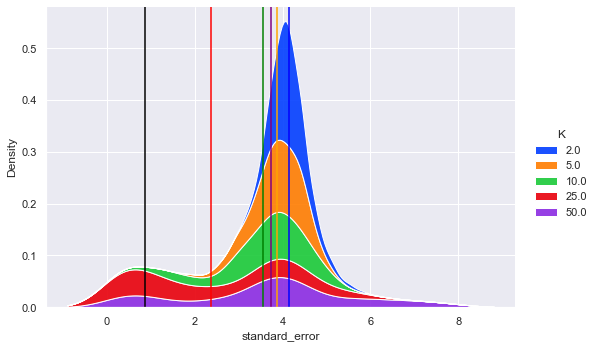

In [20]:
sns.displot(oos_residuals,
             x = 'standard_error',
             hue = 'K',
             kind = 'kde',
             multiple="stack",
             palette = 'bright',
             alpha = 0.9,
             aspect = 1.5) # width = height * aspect

plt.axvline(label='Mean 2.0', x=oos_results_summary.iloc[0, 0], color='blue')
plt.axvline(label='Mean 5.0', x=oos_results_summary.iloc[1, 0], color='orange')
plt.axvline(label='Mean 10.0', x=oos_results_summary.iloc[2, 0], color='green')
plt.axvline(label='Mean 25.0', x=oos_results_summary.iloc[3, 0], color='red')
plt.axvline(label='Mean 50.0', x=oos_results_summary.iloc[4, 0], color='purple')
plt.axvline(label='CV', x=oos_cross_validation_residual_average, color='black')


Admittedly, I don't know the properties of CV estimates as well as I should. Thus, there will be only procedural questions on the next exam. I do know that selecting K "optimally" for general datasets is an open question.

There is one other nice thing about having folds, you can estimate the standard error in your generalization estimate by pretending you have K iid samples and pretending the normal theory applies. For example, let's say K = 5. Instead of aggregating all residuals, we leave them separate and get K = 5 difference estimates for generalization error.

In [21]:
# importing dependencies
from sklearn.model_selection import KFold

# initializing model
model = LinearRegression() # intercept will fit by default

# 10 folds
K = 10
kf = KFold(n_splits=K)

# list to hold residuals
oos_cross_validation_residuals = []

for train_index , test_index in kf.split(x):
    X_train = pd.DataFrame([x[i] for i in train_index])
    y_train = pd.DataFrame([y[i] for i in train_index])

    X_test = pd.DataFrame([x[i] for i in test_index])
    y_test = pd.DataFrame([y[i] for i in test_index])
    
    model.fit(X_train,y_train)
    y_hat_g = model.predict(X_test)
     
    oos_cross_validation_residuals += [np.std(y_test - y_hat_g)]
    
oos_cross_validation_residual_mean = np.mean(oos_cross_validation_residuals)
print(oos_cross_validation_residual_mean)

oos_cross_validation_residual_std = np.std(oos_cross_validation_residuals)
print(oos_cross_validation_residual_std)

3.950922846645746
0.8584252859259888


In [22]:
# calculating confidence interval
import scipy.stats as st

confidence_interval = st.t.interval(alpha = 0.95,
                                   df = len(y) - 1,
                                   loc = oos_cross_validation_residual_mean,
                                   scale = oos_cross_validation_residual_std)

print(confidence_interval)
print(min(y), max(y))

(2.2258526513895607, 5.675993041901931)
1.2627430676861833 48.69439853538999


Although this is technically nonsense since they're not iid samples since the training set is crossed over containing mostly the same observations, at least it's something. In the above example, we've managed to capture the true generalization error.

Coverage in this confidence interval is over D. So I wouldn't gain much insight by simulating different splits with the same K.

I believe confidence intervals for generalization error is an open problem or maybe proved that you can't find them in general situations.

Here's a real data example with the `breast_cancer` dataset.

In [23]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame = True)
df = data.frame
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, random_state=None)

model = LinearRegression()
 
residuals = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    y_hat_g = model.predict(X_test)
     
    residuals += [np.std(y_test - y_hat_g)]

print(np.mean(residuals))
print(np.std(residuals))

0.24089771870604665
0.03227633906367752


In [25]:
# calculating confidence interval
import scipy.stats as st

confidence_interval = st.t.interval(alpha = 0.95,
                                   df = len(X) - 1,
                                   loc = np.mean(residuals),
                                   scale = np.std(residuals))

print(confidence_interval)

(0.17750217054311385, 0.30429326686897945)
